In [1]:
import tensorflow as tf
import numpy as np
np.set_printoptions(threshold=np.inf)

In [104]:
main_input=tf.keras.layers.Input(shape=(32,32,2), name="input_1")

x=tf.keras.layers.DepthwiseConv2D(3, strides=(2, 2), use_bias=False, name="online_cnn_fw/depthwise_conv2d_9/depthwise1")(main_input)
x=tf.keras.layers.Conv2D(32, 1, activation='relu', use_bias=False, name="online_cnn_fw/conv2d_9/Conv2D")(x)
x=tf.keras.layers.DepthwiseConv2D(3, strides=(2, 2), use_bias=False, name="online_cnn_fw/depthwise_conv2d_10/depthwise1")(x)
x=tf.keras.layers.Conv2D(64, 1, activation='relu', use_bias=False, name="online_cnn_fw/conv2d_10/Conv2D")(x)
x=tf.keras.layers.DepthwiseConv2D(3, strides=(2, 2), use_bias=False, name="online_cnn_fw/depthwise_conv2d_11/depthwise1")(x)
x=tf.keras.layers.Conv2D(128, 1, activation='relu', use_bias=False, name="online_cnn_fw/conv2d_11/Conv2D1")(x)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.BatchNormalization(name='batch_normalization')(x)
x=tf.keras.layers.Reshape((1,128))(x)

cnnmodel=tf.keras.models.Model(inputs=main_input, outputs=x)

cnnmodel.summary()

Model: "functional_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 2)]       0         
_________________________________________________________________
online_cnn_fw/depthwise_conv (None, 15, 15, 2)         18        
_________________________________________________________________
online_cnn_fw/conv2d_9/Conv2 (None, 15, 15, 32)        64        
_________________________________________________________________
online_cnn_fw/depthwise_conv (None, 7, 7, 32)          288       
_________________________________________________________________
online_cnn_fw/conv2d_10/Conv (None, 7, 7, 64)          2048      
_________________________________________________________________
online_cnn_fw/depthwise_conv (None, 3, 3, 64)          576       
_________________________________________________________________
online_cnn_fw/conv2d_11/Conv (None, 3, 3, 128)       

In [105]:
#讀取公司模型
ogmodel = tf.lite.Interpreter('AIModel/CNN.tflite')
ogmodel.allocate_tensors()
tensors = ogmodel.get_tensor_details()

#寫入權重
for i in range(len(tensors)):
    layer_name = tensors[i]['name']
    #針對Conv2D層作處理(transpose)
    if "Conv2D" in layer_name:
        try:
            layer_to_setweight = cnnmodel.get_layer(layer_name)
            layer_shape = layer_to_setweight.get_weights()[0].shape
            layer_to_setweight.set_weights([ogmodel.tensor(i)().reshape(layer_shape)])
            print(f"Weight is set for {layer_to_setweight} ({i})")
        except:
            continue
    #針對除了bn層和conv2D的層寫入權重
    else:
        try:
            layer_to_setweight = cnnmodel.get_layer(layer_name)
            layer_shape = layer_to_setweight.get_weights()[0].shape
            layer_to_setweight.set_weights([ogmodel.tensor(i)().reshape(layer_shape)])
            print(f"Weight is set for {layer_to_setweight} ({i})")
        except:
            continue

Weight is set for <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x000002949448E208> (6)
Weight is set for <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029494699888> (8)
Weight is set for <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x0000029496D67348> (9)
Weight is set for <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000294949221C8> (11)
Weight is set for <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x00000294948EFB88> (12)
Weight is set for <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029494876508> (14)


In [106]:
#針對bn層進行mean和var參數的運算

A = np.load("forBN\online_cnn_fw_batch_normalization_3_batchnorm_mul.npy")
B = np.load("forBN\online_cnn_fw_batch_normalization_3_batchnorm_sub.npy")

#分出A矩陣的正數A_p和負數A_n
Aindex = A>=0
A_p = A[A>0]
A_n = A[A<0]

#分開計算var
var_Ap = ((1**2) - ((A_p**2) * 0.001)) / (A_p**2)   #gamma=1
var_An = (((-1)**2) - ((A_n**2) * 0.001)) / (A_n**2)    #gamma=-1   

#重新計算A矩陣並確認
a = np.copy(A)
a[Aindex] = 1 / (var_Ap + 0.001)**0.5   #gamma=1
a[Aindex==False] = -1 / (var_An + 0.001)**0.5   #gamma=-1
a_check = a - A

#依A矩陣邏輯分開B矩陣B_Ap和B_An
B_Ap = B[Aindex]
B_An = B[Aindex==False]

#計算avg
avg_Ap = -B_Ap / A_p
avg_An = -B_An / A_n

#重新計算B矩陣並確認
b = np.copy(B)
b[Aindex] = (-1 * avg_Ap) / (var_Ap + 0.001)**0.5   #gamma=1
b[Aindex==False] = (-(-1) * avg_An) / (var_An + 0.001)**0.5 #gamma=-1
b_check = b - B

#組合var和avg
var = np.copy(A)
var[Aindex] = var_Ap
var[Aindex==False] = var_An

avg = np.copy(A)
avg[Aindex] = avg_Ap
avg[Aindex==False] = avg_An

diff = a-A
zipper = [*zip(a, A)]
for i in np.where(diff != 0)[0]:
    print(f"{i}: {zipper[i]}, difference: {diff[i]}")

#設定gamma矩陣
gamma = np.copy(A)
gamma[Aindex] = 1
gamma[Aindex==False] = -1

#設定beta矩陣
beta = np.zeros(128, dtype="float32")

1: (0.012167035, 0.012167036), difference: -9.313225746154785e-10
10: (0.011588607, 0.011588608), difference: -9.313225746154785e-10
11: (0.0028604812, 0.0028604814), difference: -2.3283064365386963e-10
12: (0.005871896, 0.0058718966), difference: -4.656612873077393e-10
20: (0.0033066554, 0.0033066557), difference: -2.3283064365386963e-10
35: (0.012508549, 0.012508548), difference: 9.313225746154785e-10
41: (0.0034799608, 0.0034799606), difference: 2.3283064365386963e-10
47: (0.014910069, 0.014910068), difference: 9.313225746154785e-10
51: (0.0014362223, 0.0014362225), difference: -1.1641532182693481e-10
57: (0.014085806, 0.014085805), difference: 9.313225746154785e-10
60: (0.024396524, 0.024396526), difference: -1.862645149230957e-09
73: (0.042809, 0.042808995), difference: 3.725290298461914e-09
81: (0.0009037794, 0.00090377935), difference: 5.820766091346741e-11
82: (0.0036216872, 0.003621687), difference: 2.3283064365386963e-10
90: (0.005529568, 0.0055295685), difference: -4.6566128

In [107]:
#針對bn層寫入權重 順序確定正確

layer_to_setweight = cnnmodel.get_layer('batch_normalization')
layer_to_setweight.set_weights([gamma, beta, avg, var])
print(f"Weight is set for {layer_to_setweight}")

Weight is set for <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029495968948>


In [108]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnnmodel)
kerasmodel = converter.convert()

#test
with open('kerasmodel_n1.tflite', 'wb') as f:
  f.write(kerasmodel)

INFO:tensorflow:Assets written to: C:\Users\zaqsx\AppData\Local\Temp\tmpqvmdhpr6\assets


INFO:tensorflow:Assets written to: C:\Users\zaqsx\AppData\Local\Temp\tmpqvmdhpr6\assets


In [120]:
tfmodel_n = tf.lite.Interpreter('kerasmodel_n1.tflite')
tfmodel_n.allocate_tensors()
tfinputs_n = tfmodel.get_input_details()
tfoutputs_n = tfmodel.get_output_details()
tftensors_n = tfmodel.get_tensor_details()

In [121]:
tftensors_n

[{'name': 'online_cnn_fw/depthwise_conv2d_9/depthwise1_input',
  'index': 0,
  'shape': array([ 1, 32, 32,  2]),
  'shape_signature': array([ 1, 32, 32,  2]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'sequential/global_average_pooling2d/Mean/reduction_indices',
  'index': 1,
  'shape': array([2]),
  'shape_signature': array([2]),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'sequential/reshape/Reshape/shape',
  'index': 2,
  'shape': array([3]),
  'shape_signature': array([3]),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array

In [114]:
ogmodel = tf.lite.Interpreter('AIModel\CNN.tflite')
ogmodel.allocate_tensors()
inputs = ogmodel.get_input_details()
outputs = ogmodel.get_output_details()
tensors = ogmodel.get_tensor_details()

tfmodel = tf.lite.Interpreter('kerasmodel_n.tflite')
tfmodel.allocate_tensors()
tfinputs = tfmodel.get_input_details()
tfoutputs = tfmodel.get_output_details()
tftensors = tfmodel.get_tensor_details()

In [116]:
tfmodel.tensor(24)()

array([[[ 1.07506418e+01,  5.97814865e+01,
         -4.30011526e-02,  7.97371368e+01,
          3.70105743e+01,  6.67109070e+01,
          1.42501175e+02,  2.22888279e+01,
          5.29986076e+01,  1.06536416e+04,
          1.47300568e+01,  4.51696205e+00,
          5.20773649e+00, -1.52540118e-01,
          6.67638481e-01,  6.16418190e+01,
          2.56445351e+01,  1.06630371e+02,
          2.80474529e+01,  2.20096493e+01,
         -6.09732941e-02,  3.94677305e+00,
          2.41772118e+01,  6.81552963e+01,
          6.11520863e+00,  9.62326336e+00,
          1.90199539e+02,  3.58010178e+01,
         -1.31769404e-01,  6.02864361e+00,
         -1.33606225e-01, -7.38503784e-02,
          1.40646470e+00,  1.46058470e-01,
         -4.70405184e-02,  9.53899002e+00,
          2.07473469e+01,  1.47827787e+01,
          2.85285892e+01,  3.80317535e+01,
         -1.28688574e-01,  9.47043151e-02,
          2.14770734e-01,  2.74031878e+00,
          7.70619659e+01, -1.53386742e-01,
          2

In [89]:
a = np.load('data_PatPat_0001_2024_07_17_11_48_29.h5.npy')

TimeSp = 35

D = []
for i in range(100000):
    if i + TimeSp >= len(a[0, 0, 0]):
        break
    D.append(a[:, :, :, i:i + TimeSp])

D_reshape = np.reshape(D, (-1, 2, 32, 32, TimeSp))
D_reshape = np.transpose(D_reshape, [0, 4, 2, 3, 1]).reshape(-1,32,32,2)

(1, 15, 15, 2)
[[[[5.318876 1.245402]
   [-0.101880 0.127822]
   [-5.565186 0.000000]
   [-18.628710 -47.586380]
   [-1.669214 0.000000]
   [-22.396564 -3.691536]
   [5.051628 38.869614]
   [3.440972 7.207211]
   [-5.540621 -7.431215]
   [0.000000 -9.531393]
   [1.089535 0.000000]
   [-3.405120 4.255285]
   [2.197464 -3.333273]
   [35.269279 0.000000]
   [-0.878348 9.840063]]

  [[57.507355 -31.918400]
   [9.221760 3.646676]
   [-0.225338 0.101526]
   [-1.082380 0.201922]
   [-4.146367 -49.123199]
   [-21.505140 -0.249147]
   [-22.445812 -0.463387]
   [-3.015058 21.827265]
   [0.182154 11.067356]
   [-12.779398 -20.643059]
   [0.000000 8.695315]
   [0.418508 0.000000]
   [0.125101 1.399107]
   [0.366603 -0.723222]
   [22.552494 0.000000]]

  [[2.082721 9.978105]
   [17.332172 -33.803879]
   [40.071899 6.530777]
   [24.167870 1.418937]
   [-3.010885 3.755979]
   [-11.921211 -45.319706]
   [0.175599 0.517877]
   [-11.007059 -20.533073]
   [7.140891 33.888935]
   [-3.315464 15.815346]
   

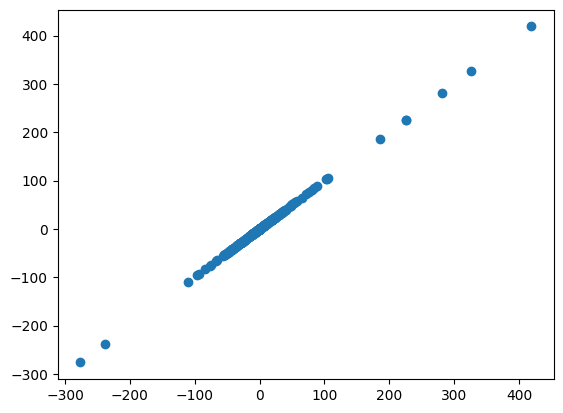

In [14]:
import matplotlib.pyplot as plt

print(tfmodel.get_tensor(15).shape)
print(np.array2string(tfmodel.get_tensor(15), formatter={'float_kind':lambda x: "{:.6f}".format(x)}))
print(np.array2string(ogmodel.get_tensor(15), formatter={'float_kind':lambda x: "{:.6f}".format(x)}))

plt.scatter(tfmodel.get_tensor(15), ogmodel.get_tensor(15))

In [ ]:
cnnmodel.save("ourCNNmodel.h5")